### Real Estate Multi-label room classification

The task here is to classify room images into multiple labels. This is often useful when single image, for example has both dining_room and kitchen alongwith other rich labels such as kitchen_island, appliances, chandelier, etc. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
PATH = Path('batch_images/redfin/')
PATH

PosixPath('batch_images/redfin')

#### Load Dataset

In [3]:
df = pd.read_csv('multi_label.csv')

In [4]:
df.Label = df.Label.apply(json.loads)

In [5]:
labels = []
img_list = []
for row in df.iterrows():
    x = row[1].Label['multi-label']
    labels.append(' '.join(x))
    img_list.append(row[1].Image_path)

In [6]:
new_df = pd.DataFrame()
new_df['image_path'] = img_list
new_df['label'] = labels

In [7]:
new_df.head()

,image_path,label
0,5000_3.jpg,kitchen ceramic_flooring kitchen_island applia...
1,5000_4.jpg,living_room ceramic_flooring window_blinds win...
2,5000_5.jpg,living_room ceramic_flooring carpet
3,5000_6.jpg,bedroom window_drapes window_blinds carpet cei...
4,5000_7.jpg,window_drapes window_blinds ceiling_fan bedroom


In [8]:
np.random.seed(42)
data = (ImageList.from_df(new_df,PATH).split_by_rand_pct(0.05)
       .label_from_df(label_delim=' ').transform(get_transforms(),size=224)
        .databunch(bs=4).normalize(imagenet_stats))

In [9]:
data.sanity_check

<bound method DataBunch.sanity_check of ImageDataBunch;

Train: LabelList (672 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
kitchen;ceramic_flooring;kitchen_island;appliances,living_room;ceramic_flooring;window_blinds;window_drapes;carpet,living_room;ceramic_flooring;carpet,bedroom;window_drapes;window_blinds;carpet;ceiling_fan,window_drapes;window_blinds;ceiling_fan;bedroom
Path: batch_images/redfin;

Valid: LabelList (35 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
dining_room;chandelier;hardwood_flooring,kitchen;ceramic_flooring;appliances,exterior;yard,hardwood_flooring;kitchen_island;kitchen;sliding_windows,exterior;yard
Path: batch_images/redfin;

Test: None>

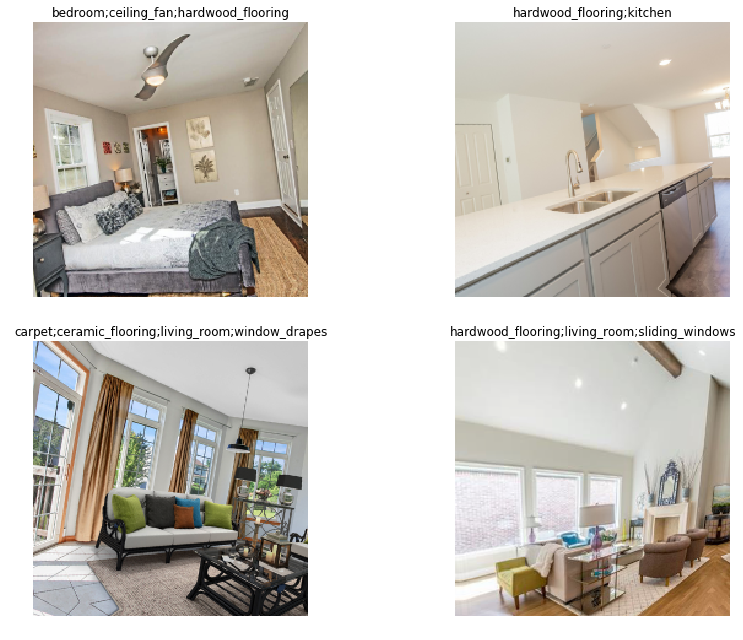

In [10]:
data.show_batch(rows=2, figsize=(12,9))

### Train Model

In [11]:
acc_02 = partial(accuracy_thresh, thresh=0.7)
learn = cnn_learner(data, models.resnet34, metrics=[acc_02],model_dir = Path('models').absolute())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


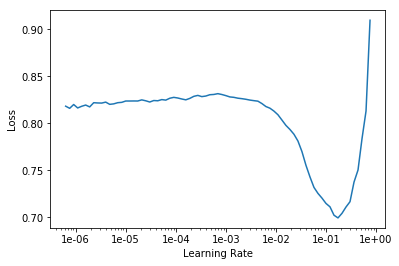

In [12]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.283090,0.138893,0.947755,00:30
1,0.212124,0.127691,0.945306,00:32
2,0.179996,0.108738,0.953469,00:30
3,0.173445,0.100493,0.952653,00:30


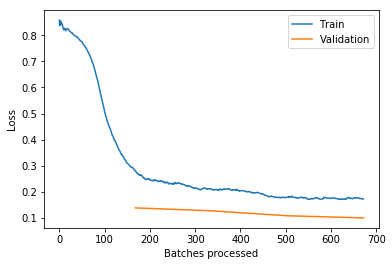

In [13]:
learn.fit_one_cycle(4,max_lr=slice(1e-02))
learn.recorder.plot_losses()

In [14]:
learn.save('redfin-multi-label-stage-1')

In [21]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


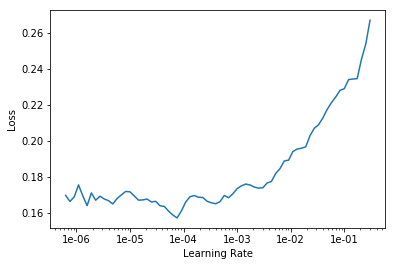

In [23]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.189876,0.190636,0.932245,00:31
1,0.181586,0.133261,0.949388,00:31
2,0.169282,0.110372,0.955918,00:31


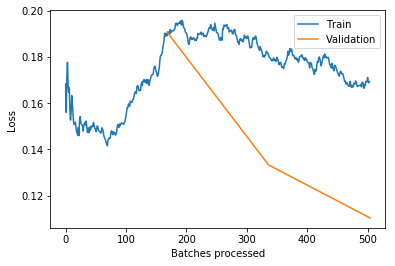

In [24]:
learn.fit_one_cycle(3,max_lr=slice(1e-04,1e-03))
learn.recorder.plot_losses()

In [25]:
learn.save('redfin-multi-label-stage-2')

#### Check train results

In [ ]:
learn.show_results()